# Fashion-MNIST

Dataset de ropa y accesorios.

Imágenes en escala de grises de 28x28 píxeles

60K casos de entrenamiento

10K casos de test

10 clases

<center><img src='assets/table.png' width=200px></center>

<center><img src='assets/fashion-mnist-sprite.png' width=700px></center>

## Preparación

### Importamos las librerías que vamos a usar

In [1]:
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

### Definimos las transformaciones de entrada y obtenemos el dataset

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
test_data = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)

In [3]:
train_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Split: train
    Root Location: /home/joacoib/.pytorch/F_MNIST_data/
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                         )
    Target Transforms (if any): None

Este dataset ya tiene un conjunto de test separado del de train y Torchvision lo respeta. Pero necesitamos datos de validación, que vamos a obtener como una muestra de los de entrenamiento.

In [4]:
# Vamos a separar un 20% de los datos para validación
valid_size = 0.2

# Obtenemos todos los indices del set de train como una lista
num_train = len(train_data)
indices = list(range(num_train))
# Desordenamos
np.random.shuffle(indices)
# Separamos el 20% que quedo al final de la lista
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

In [5]:
# Creamos SubsetRandomSamplers para que muestreen aleatoriamente y sin reemplazo nuestros sets
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [6]:
# Creamos los DataLoaders para que carguen nuestros datos
train_loader = DataLoader(train_data, batch_size=64, sampler=train_sampler)
valid_loader = DataLoader(train_data, batch_size=64, sampler=valid_sampler)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

### Veamos alguna de las imágenes que estamos cargando

Sandal


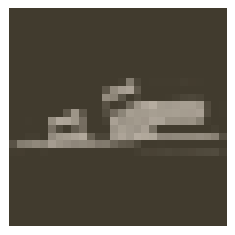

In [8]:
from helper import imshow
classes = ['T-shirt/top',
           'Trouser',
           'Pullover',
           'Dress',
           'Coat',
           'Sandal',
           'Shirt',
           'Sneaker',
           'Bag',
           'Ankle Boot']
image, label = next(iter(train_loader))
print(classes[label[0]])
imshow(image[0,:]);

### Veámosla en más detalle

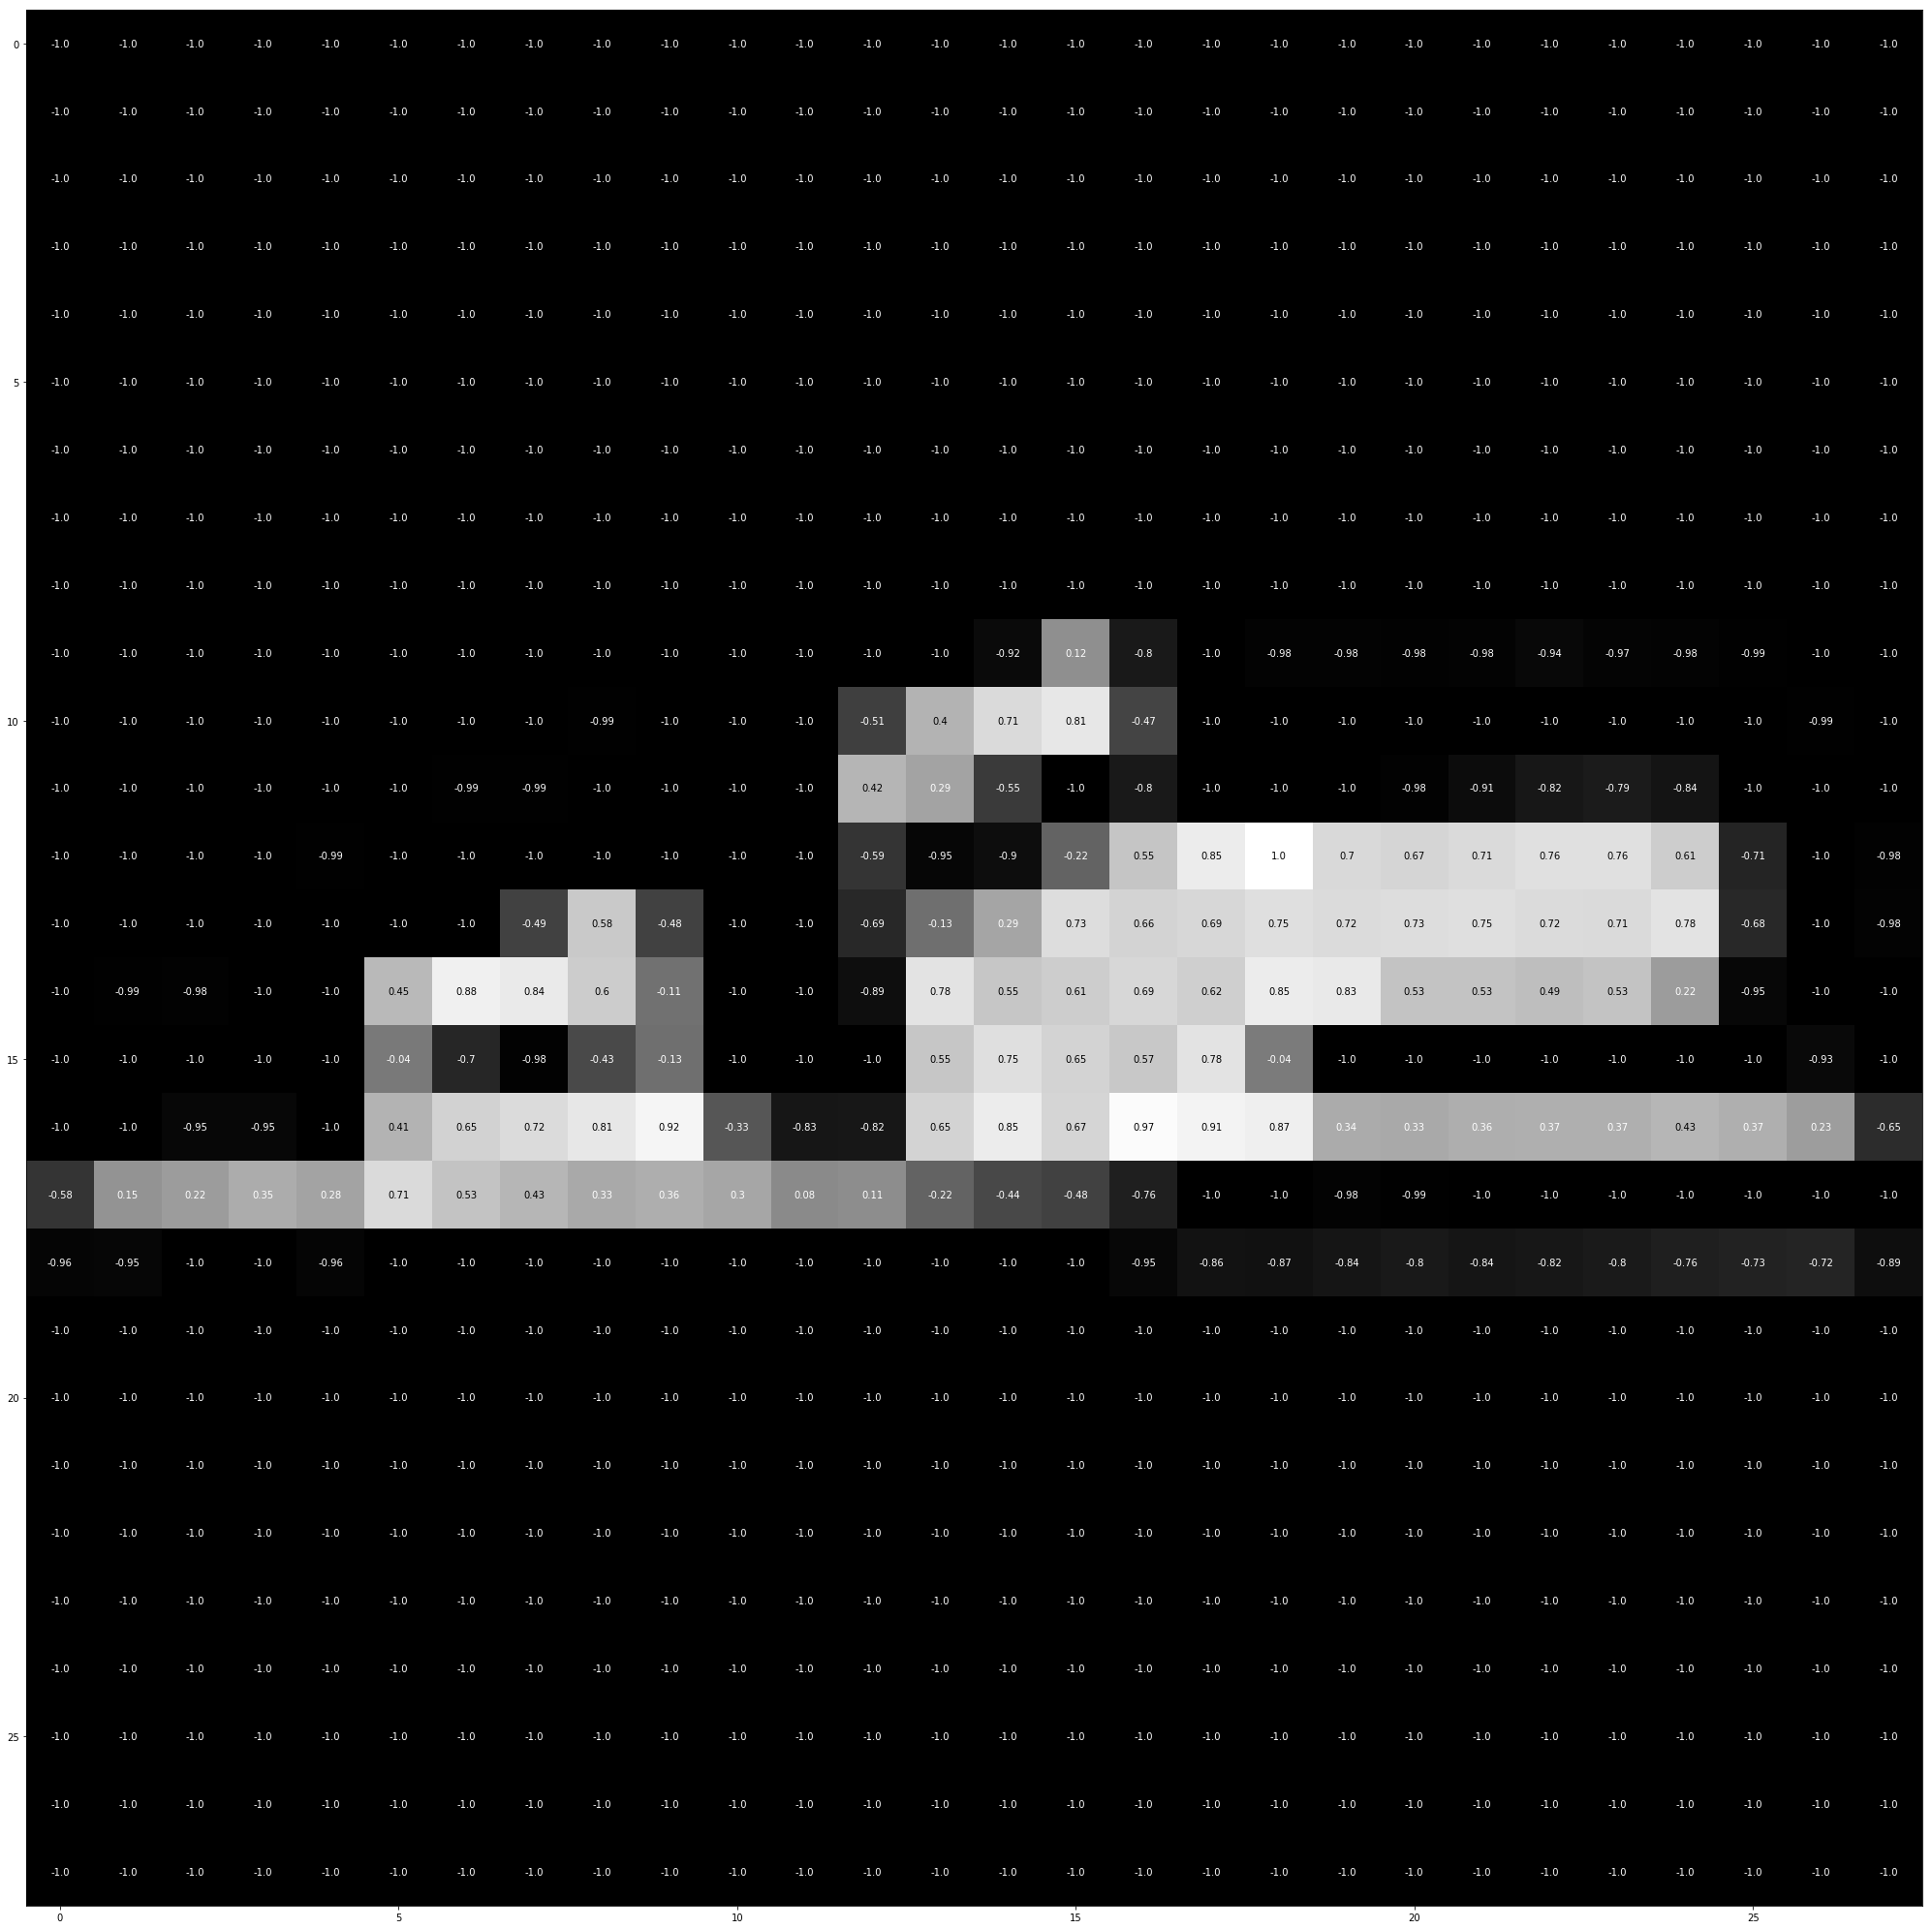

In [9]:
from matplotlib import pyplot as plt
img = image[0, :].numpy()[0]
fig = plt.figure(figsize = (36, 36)) 
plt.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        plt.annotate(str(val), xy=(y,x),
                horizontalalignment='center',
                verticalalignment='center', size=10,
                color='white' if img[x][y]<thresh else 'black')

## Definamos nuestra red

Nuestras imágenes tienen 28x28 píxeles en escala de grises, es decir cada imagen se compone de 784 valores.
Por otro lado tenemos 10 clases.
Esto significa que la entrada de nuestra red tiene que ser de 784 valores y la salida de 10.

### <center>Cuántas capas va a tener nuestra red?</center>

<center><img src='assets/3.png' width=500px></center>

### <center> Qué función de activación vamos a usar para agregar no linealidad?</center>

<center>RELU. Rectified Linear Unit.
<img src='assets/relu.jpg' width=500px></center>

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        
        x = F.dropout(F.relu(self.fc1(x)), p=.5)
        x = F.dropout(F.relu(self.fc2(x)), p=.5)
        x = self.fc3(x)
        
        return x

<center><img src='assets/no_idea.png' width=500px></center>

In [11]:
model = Classifier()

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

<center><img src='assets/cuda.jpg' width=500px></center>

In [12]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss
from torch.optim import Adam

In [13]:
optimizer = Adam(model.parameters())
trainer = create_supervised_trainer(model, optimizer, F.cross_entropy, device=device)
evaluator = create_supervised_evaluator(model,
                                        metrics={'accuracy': Accuracy(),
                                                 'ce': Loss(F.cross_entropy)},
                                        device=device)

In [14]:
train_loss = []
valid_loss = []

valid_loss_min = np.Inf

In [15]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    evaluator.run(train_loader)
    metrics = evaluator.state.metrics
    avg_accuracy = metrics['accuracy']
    avg_ce = metrics['ce']
    train_loss.append(avg_ce)
    print(
        "Training Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.6f}"
        .format(engine.state.epoch, avg_accuracy, avg_ce)
    )

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    global valid_loss_min
    evaluator.run(valid_loader)
    metrics = evaluator.state.metrics
    avg_accuracy = metrics['accuracy']
    avg_ce = metrics['ce']
    valid_loss.append(avg_ce)
    print(
        "Validation Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.6f}"
        .format(engine.state.epoch, avg_accuracy, avg_ce))
    if avg_ce <= valid_loss_min:
            print('(( Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...  ))'.format(
            valid_loss_min,
            avg_ce))
            torch.save(model.state_dict(), 'model_fashion.pt')
            valid_loss_min = avg_ce
    print('===========================================================================')

In [16]:
state = trainer.run(train_loader, max_epochs=15)

Training Results - Epoch: 1  Avg accuracy: 0.84 Avg loss: 0.417668
Validation Results - Epoch: 1  Avg accuracy: 0.84 Avg loss: 0.438782
(( Validation loss decreased (inf --> 0.438782).  Saving model ...  ))
Training Results - Epoch: 2  Avg accuracy: 0.87 Avg loss: 0.341462
Validation Results - Epoch: 2  Avg accuracy: 0.86 Avg loss: 0.381038
(( Validation loss decreased (0.438782 --> 0.381038).  Saving model ...  ))
Training Results - Epoch: 3  Avg accuracy: 0.89 Avg loss: 0.308124
Validation Results - Epoch: 3  Avg accuracy: 0.88 Avg loss: 0.357117
(( Validation loss decreased (0.381038 --> 0.357117).  Saving model ...  ))
Training Results - Epoch: 4  Avg accuracy: 0.88 Avg loss: 0.305780
Validation Results - Epoch: 4  Avg accuracy: 0.87 Avg loss: 0.370346
Training Results - Epoch: 5  Avg accuracy: 0.90 Avg loss: 0.276960
Validation Results - Epoch: 5  Avg accuracy: 0.88 Avg loss: 0.348183
(( Validation loss decreased (0.357117 --> 0.348183).  Saving model ...  ))
Training Results - Ep

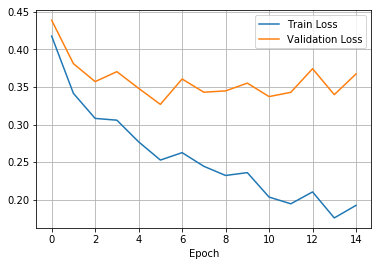

In [17]:
plt.plot(range(15), train_loss, label='Train Loss')
plt.plot(range(15), valid_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.grid()
plt.legend()

In [18]:
model.load_state_dict(torch.load('model_fashion.pt'))

In [19]:
tester = create_supervised_evaluator(model,
                                     metrics={'accuracy': Accuracy(),
                                              'ce': Loss(F.cross_entropy)},
                                     device=device)

In [20]:
tester.run(test_loader)
metrics = evaluator.state.metrics
avg_accuracy = metrics['accuracy']
print('Test Accuracy: %.2f%%' % (avg_accuracy*100))

Test Accuracy: 88.08%


<center><img src='assets/success.jpg' width=500px></center>

In [21]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()

for data, target in test_loader:

    if torch.cuda.is_available():
        data, target = data.cuda(), target.cuda()

    output = model(data)

    _, pred = torch.max(output, 1)    

    correct_tensor = pred.eq(target.data.view_as(pred))
    
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())

    for i in range(len(target.data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

In [22]:
for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %11s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %11s: N/A (no training examples)' % (classes[i]))

Test Accuracy of T-shirt/top: 82% (820/1000)
Test Accuracy of     Trouser: 97% (974/1000)
Test Accuracy of    Pullover: 80% (803/1000)
Test Accuracy of       Dress: 84% (846/1000)
Test Accuracy of        Coat: 85% (852/1000)
Test Accuracy of      Sandal: 93% (930/1000)
Test Accuracy of       Shirt: 67% (673/1000)
Test Accuracy of     Sneaker: 92% (923/1000)
Test Accuracy of         Bag: 96% (969/1000)
Test Accuracy of  Ankle Boot: 97% (972/1000)


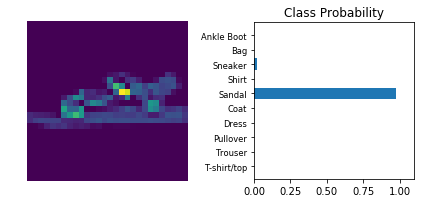

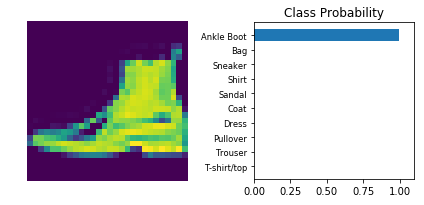

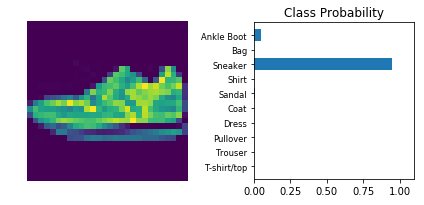

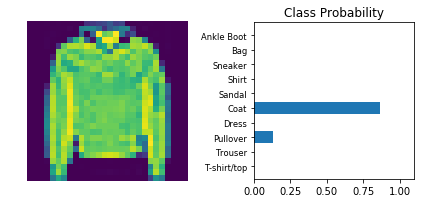

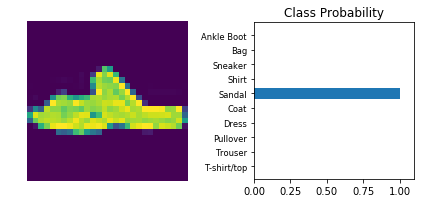

In [23]:
from helper import view_classify
model.eval()
images, labels = next(iter(test_loader))
for i in range(5):
    img = images[i]
    img_tensor = img.cpu()
    if torch.cuda.is_available():
        img_tensor = img_tensor.cuda()

    ps = F.softmax(model(img_tensor), 1)
    # Plot the image and probabilities
    view_classify(img, ps.cpu(), version='Fashion')

## <center> Preguntas? </center>
<center><img src='assets/questions.jpg' width=500px></center>
